In [1]:
push!(LOAD_PATH,pwd())
using ProfileView
using constants
using types10
using Optim
using PyPlot
using dataPS
include("DOSfunctions.jl")
include("userfunctions.jl")
include("propertyfuncs.jl")

kltSA (generic function with 1 method)

In [2]:
Eoff=5.0
Ts=collect(300.0:10.0:900.0)
######################################################################################
##for Liu x=0.6 best fit x=0.635 N=-1.45e20
######################################################################################
numofn=[5.0e18]#,-1.22e18,-1.02e18,-0.94e18]#-9.5e19,-1.75e20,-3.0e19,-0.9e20]#Sample 1 -3.0e19, Sample 2 -1.25e20,
numofnn=[1e17]#,1e18,1e18,1e18]
#Sample 3 -1.75e20, Sample Sb 0.75% -1.03e20, #
xs=[0.6]#,0.8,0.7,0.61]#collect(0.0:0.01:1.0)
Es=collect(0.0:0.1:3.0)

var0=[Ts[1],xs[1]]

EX3(var)=Eoff#+Egx3(var[1],var[2])
EX1(var)=Ec0(var[2])+EX3(var)
ELH(var)=Eoff-Egx3(var[1],var[2])
EHH(var)=Eoff-Egx3(var[1],var[2])
Ecutoff=0.0
effMassX1(var)=X1effMass(var[1])*me
effMassX3(var)=0.38*me
effMassLH(var)=-1.0*me
effMassHH(var)=-1.5*me

alphaX1(var)=0.0#EX1(var0)
alphaX3(var)=0.0#EX1(var0)
alphaLH(var)=0.0#EX3(var0)
alphaHH(var)=0.0#EX3(var0)

function Da(band::parBandTxC,x::Float64)
    Da=7.0#9.0-1.5*x*x
    Dv=1.0
    if band==bandX3 ||  band==bandX1
        return Da
    end
    if band==bandHH ||  band==bandLH
        return Dv
    end
end

bandX3=parBandTxC(true,1.0,effMassX3(var0),alphaX3(0.0),EX3(var0),0.0,[EX3],[effMassX3],[alphaX3],var0)
bandX1=parBandTxC(true,1.0,effMassX1(var0),alphaX1(0.0),EX1(var0),0.0,[EX1],[effMassX1],[alphaX1],var0)
bandHH=parBandTxC(true,1.0,effMassHH(var0),alphaHH(0.0),EHH(var0),Ecutoff,[EHH],[effMassHH],[alphaHH],var0)
bandLH=parBandTxC(true,1.0,effMassLH(var0),alphaLH(0.0),ELH(var0),Ecutoff,[ELH],[effMassLH],[alphaLH],var0)
bndstTx=BandStrucTx([bandLH,bandHH,bandX1,bandX1,bandX1,bandX3,bandX3,bandX3],var0)#
#bndstTx=BandStrucTx([bandLH,bandX1],var0)#

#vartau0=[bandC.effMass,Ts[1],Ec(var0),xs[1],Ec(var0),bandC,numofn[1]*1e6,bndstTx,numofnn[1]*1e6,bandV]
vartau0=[bandX3.effMass,Ts[1],EX1(var0),xs[1],EX1(var0),bandX3,numofn[1]*1e6,bndstTx,numofnn[1]*1e6,bandLH]
#var array: var[1]: effMass , var[2]:T, var[3]:E, var[4]:x, var[5]:Ef, 
#var[6]:band, var[7]:NII var[8]:bndst
#tauAC(var)=tauAC_func(Cl(var[4]),acPhDa(var[4]),var[2],var[1],var[3],var[6])
tauAC(var)=tauAC_func(Cl(var[4]),Da(var[6],var[4]),var[2],var[1],var[3],var[6])
tauPOP(var)=tauPOP_func(epsilon0_x(var[4]),epsilonhf_x(var[4]),var[6],var[5],var[2],var[1]
,var[3],tauPOPIIint(var[5],var[2],var[4],var[6]),var[7],opPhE(var[4]),var[8])
tauPOP2(var)=tauPOP2lowN_func(epsilon0_x(var[4]),epsilonhf_x(var[4]),var[6],var[5],var[2],var[1],
var[3],opPhE(var[4]))
tauPOP3(var)=tauPOP3_func(epsilon0_x(var[4]),epsilonhf_x(var[4]),var[6],var[5],var[2],var[1],
var[3],opPhE(var[4]))
tauII2(var)=tauII2_func(epsilon0_x(var[4]),epsilonhf_x(var[4]),var[6],var[5],var[2],var[7],var[1],var[3],var[8])
tauNI(var)=tauNI_func(epsilon0_x(var[4]),var[1],var[9])
tauTOTTx=tau_electron_B([tauAC,tauII2,tauNI,tauPOP3],vartau0)#,tauII2,tauPOP2,tauPOP3

xmax=3.0

3.0

In [3]:
@time (Efs,sigmas,seebecks,kes,kees,kehs,kbis,sigmaes,sigmahs,seebeckes,seebeckhs)=electronicPropsiso(bndstTx,xs,Ts,numofn,numofnn,tauTOTTx,xmax)
x=3.0

 53.795782 seconds (233.85 M allocations: 43.046 GiB, 12.11% gc time)


3.0

In [4]:
T_EF_Dict=Dict()
for (Ti,Tx) in enumerate(Ts)
    T_EF_Dict[Tx]=(Efs[Ti])    
end
T_EF_Dict_Array=Array{Dict{Float64,Float64},2}(undef,length(numofn),length(xs))
Dict_temp=Dict()
Efsr=Array{Float64,3}(undef,length(Ts),length(numofn),length(xs))
for (j,jn) in enumerate(numofn)
    for (k,kx) in enumerate(xs) 
        for (i,iT) in enumerate(Ts)
            Efsr[i,j,k]=Efs[i,j,k]-EX3(0.0)
            Dict_temp[iT]=Efsr[i,j,k]
            T_EF_Dict_Array[j,k]=Dict_temp 
        end
    end
end
#foreach(i->println("$i= ",Ts[i]),1:length(Ts))
#Efsr

In [5]:
#println("-1")
#############Lattice Thermal Conductivity Parameters###############
function klpar(con::Float64,p::Float64,NP::Float64)
    thetaL=52.3e12*hbar/kB # K 
    thetaT=29.7e12*hbar/kB  # K
    vL=(1-con)*7700+con*4900    # m/s
    vT=(1-con)*4900+con*3000    # m/s
    gammaL=2.5*(1-con)+1.7*con
    gammaT=2.5*(1-con)+1.7*con
    M=(2*(24.305e-3)+(28.0855e-3*(1-con)+118.71e-3*con))/3/Nav
    V=((1-con)*(6.39e-10)^3+con*(6.77e-10)^3)/12
    a=V^(1.0/3.0)
    ro=M/V
    Vdj=(((6.39e-10)^3)/((1-con)*(6.39e-10)^3+con*(6.77e-10)^3))^(1/3)
    jL=vL/7700*Vdj
    jT=vT/4900*Vdj
    thetaLx=thetaL*jL
    thetaTx=thetaT*jT
    ##########Boundary Scattering###############3
    D=11e-9
    p=0.65
    ##########Alloy Scattering###################
    mbar=(28.0855*(1-con)+118.71*con)
    GammaSiSn=(1-con)*((28.0855-mbar)/mbar)^2+con*((118.71-mbar)/mbar)^2
    GammaMgSiSn=2*((mbar/(24.305+mbar))^2*GammaSiSn);         
    ##########Electron Scattering###################
    Ehp=1.0*q
    Eep=5.0*q
    xsp=xs[1]
    Tp=300.0
    mdx1=0.67*me
    mdx3=0.38*me
    mdLH=1.0*me
    mdHH=1.2*me
    Efx3=0.2589
    Efx1=0.2589
    ##########Nanoparticle Scattering###################
    #NP=0
    #alpha=1.0
    Rnp=1/2*15.0e-9#
    Vnp=4/3*pi*(Rnp)^3
    rhonp=NP/100/Vnp
    rhoM=3.0
    rhoT=3.78
    alphaNP=0.2289#1-exp(-1*(rhoT-rhoM)/rhoM);
#vartauPH0=[[0.02],Ts[1],gammaL,gammaT,xsp,thetaCLx,thetaCTx,thetaCTx,MSi,MGe,VSi,a,T_EF_Dict,0.0]
    Tsindex=1#25
    numberofnindex=1
    xsindex=1
    vartauPH0=[ [0.02],  Ts[1],   gammaL,  gammaT, con,#5
        thetaLx, thetaTx, thetaTx, M,   M, #10
        V, a, T_EF_Dict_Array, Eep, alphaNP, #15
        Rnp, thetaLx, thetaTx, vL, vT, #20
        vL, vT, p, NP,Tsindex,#25
        numberofnindex,xsindex,p,D,GammaMgSiSn,#30
        mdx1,mdx3,Efx1,Efx3,ro,#35,
        NP,alphaNP,Rnp,Vnp,rhonp, #40
        Ehp,mdHH,mdLH
        ]  
    thetaCLx=thetaCL(vartauPH0[12],vartauPH0[5],vartauPH0[17],vartauPH0[19],vartauPH0[11])
    thetaCTx=thetaCT(vartauPH0[12],vartauPH0[5],vartauPH0[18],vartauPH0[19],vartauPH0[11])
    #println("2")
    tauPHNLf(var)=tauPH_NL(var[3],var[11],var[1],var[2],var[9],var[21])
    tauPHNTf(var)=tauPH_NT(var[4],var[11],var[1],var[2],var[9],var[22]) 

    tauPHULf(var)=tauPH_U(var[3],var[1],var[2],var[9],var[19],var[17])
    tauPHUTf(var)=tauPH_U(var[4],var[1],var[2],var[9],var[20],var[18])

    tauPHALLLf(var)=tauPH_ALL(var[30],var[11],var[1],var[2],var[19])
    tauPHALLTf(var)=tauPH_ALL(var[30],var[11],var[1],var[2],var[20])
   
    tauPHeLfLH(var)=tauPH_e(var[41],var[43],var[35],(var[13][var[26],var[27]])[var[2]],var[1],var[2],var[21])
    tauPHeTfLH(var)=tauPH_e(var[41],var[43],var[35],(var[13][var[26],var[27]])[var[2]],var[1],var[2],var[22])

    tauPHeLfHH(var)=tauPH_e(var[41],var[42],var[35],(var[13][var[26],var[27]])[var[2]],var[1],var[2],var[21])
    tauPHeTfHH(var)=tauPH_e(var[41],var[42],var[35],(var[13][var[26],var[27]])[var[2]],var[1],var[2],var[22])


    tauPHeLfX3(var)=tauPH_e(var[14],var[32],var[35],(var[13][var[26],var[27]])[var[2]],var[1],var[2],var[21])
    tauPHeTfX3(var)=tauPH_e(var[14],var[32],var[35],(var[13][var[26],var[27]])[var[2]],var[1],var[2],var[22])

    tauPHeLfX1(var)=tauPH_e(var[14],X1effMass(var[2])*me,var[35],(var[13][var[26],var[27]])[var[2]]-Ec0(0.6)
        ,var[1],var[2],var[21])
    tauPHeTfX1(var)=tauPH_e(var[14],X1effMass(var[2])*me,var[35],(var[13][var[26],var[27]])[var[2]]-Ec0(0.6)
        ,var[1],var[2],var[22])

    tauPHBLf(var)=tauPH_B(var[19],var[28],var[29])
    tauPHBTf(var)=tauPH_B(var[20],var[28],var[29])
    #println("3")

    tauPHNPLf(var)=tauPH_NP(var[37],var[40],var[38],var[1],var[2],var[19])
    tauPHNPTf(var)=tauPH_NP(var[37],var[40],var[38],var[1],var[2],var[20])

    tauPHTOTL=tau_phonon_B([tauPHNLf,tauPHULf,tauPHBLf,tauPHALLLf,tauPHeLfLH,tauPHeLfHH,tauPHNPLf],vartauPH0)#,tauPHNPLf,tauPHALLLf,tauPHeLf,tauPH_eLf ,tauPHALLLf ,tauPHBLf,,tauPHULf
    tauPHNL=tau_phonon_B([tauPHNLf],vartauPH0) #tauPHeLfX3,tauPHeLfX1
    tauPHRL=tau_phonon_B([tauPHULf,tauPHBLf,tauPHALLLf,tauPHeLfLH,tauPHeLfHH,tauPHNPLf],vartauPH0) #,tauPHNPLf,tauPHALLLf,tauPHeLf,tauPHALLLf,tauPH_eLf] ,tauPHBLf

    tauPHTOTTx=tau_phonon_B([tauPHNTf,tauPHUTf,tauPHALLTf,tauPHeTfLH,tauPHeTfHH,tauPHBTf,tauPHNPTf],vartauPH0) #,tauPHNPTf,tauPHALLTf,tauPHeTf,tauPHALLTf,tauPH_eTf ,tauPHBTf
    tauPHNTx=tau_phonon_B([tauPHNTf],vartauPH0)
    tauPHRTx=tau_phonon_B([tauPHUTf,tauPHALLTf,tauPHeTfLH,tauPHeTfHH,tauPHBTf,tauPHNPTf],vartauPH0) #,tauPHNPTf,tauPHALLTf,tauPHeTf,tauPHALLTf,tauPH_eTf ,tauPHBTf#

    tauPHTOTTy=tau_phonon_B([tauPHNTf,tauPHUTf,tauPHBTf,tauPHALLTf,tauPHeTfHH,tauPHeTfLH,tauPHNPTf],vartauPH0) #,tauPHNPTf,tauPHALLTf,tauPHeTf,tauPHALLTf,tauPH_eTf tauPHBTf
    tauPHNTy=tau_phonon_B([tauPHNTf],vartauPH0)
    tauPHRTy=tau_phonon_B([tauPHUTf,tauPHBTf,tauPHALLTf,tauPHeTfHH,tauPHeTfLH,tauPHNPTf],vartauPH0) #,tauPHNPTf,tauPHALLTf,tauPH_eTf ,tauPHBTf,tauPHALLTf,tauPHeTf
    #println("4")
    tauPHL=[tauPHTOTL,tauPHNL,tauPHRL]
    tauPHTx=[tauPHTOTTx,tauPHNTx,tauPHRTx]
    tauPHTy=[tauPHTOTTx,tauPHNTx,tauPHRTx]
    return (vartauPH0,tauPHTOTL,tauPHNL,tauPHRL,tauPHTOTTx,tauPHNTx,tauPHRTx,tauPHTOTTy,tauPHNTy,tauPHRTy,tauPHL,tauPHTx,tauPHTy)
end
xmax=1.0

1.0

In [6]:
(vartauPH0,tauPHTOTL,tauPHNL,tauPHRL,tauPHTOTTx,tauPHNTx,tauPHRTx,tauPHTOTTy,tauPHNTy,tauPHRTy,tauPHL,tauPHTx,tauPHTy)=klpar(0.6,0.65,0.0)
klsM=Array{Float64}(undef,length(Ts),length(numofn),length(xs))
for (iT,iTx) in enumerate(Ts)    
   (IL1,ITx1,IL2,ITx2,IL3,ITx3,kL,kTx,kTy,klsM[iT,1,1])= klt(tauPHTOTL,tauPHNL,tauPHRL,tauPHTOTTx,tauPHNTx,tauPHRTx,tauPHTOTTy,tauPHNTy,
        tauPHRTy,iTx,[vartauPH0[21],vartauPH0[22],vartauPH0[22]])
    #println("T=", iTx, " kl= " ,round(klsM[iT,1,1]*10000)/10000)
   # println("IL1= ",IL1," IL2= ",IL2," IL3= ",IL3," ITx1= ",ITx1," ITx2= ",ITx2," ITx3= ",ITx3," kL/3=",kL,    " kTx/3=",kTx," kTy/3=",kTy)
end

In [7]:
(vartauPH0,tauPHTOTL,tauPHNL,tauPHRL,tauPHTOTTx,tauPHNTx,tauPHRTx,tauPHTOTTy,tauPHNTy,tauPHRTy,tauPHL,tauPHTx,tauPHTy)=klpar(0.0,0.65,0.0)
kls0=Array{Float64}(undef,length(Ts),length(numofn),length(xs))
for (iT,iTx) in enumerate(Ts)    
   (IL1,ITx1,IL2,ITx2,IL3,ITx3,kL,kTx,kTy,kls0[iT,1,1])= klt(tauPHTOTL,tauPHNL,tauPHRL,tauPHTOTTx,tauPHNTx,tauPHRTx,tauPHTOTTy,tauPHNTy,tauPHRTy,iTx,[vartauPH0[21],vartauPH0[22],vartauPH0[22]])
    #println("T=", iTx, " kl= " ,round(kls0[iT,1,1]*10000)/10000)
    #println("IL1= ",IL1," IL2= ",IL2," IL3= ",IL3," ITx1= ",ITx1," ITx2= ",ITx2," ITx3= ",ITx3," kL/3=",kL,    " kTx/3=",kTx," kTy/3=",kTy)
end

In [8]:
(vartauPH0,tauPHTOTL,tauPHNL,tauPHRL,tauPHTOTTx,tauPHNTx,tauPHRTx,tauPHTOTTy,tauPHNTy,tauPHRTy,tauPHL,tauPHTx,tauPHTy)=klpar(1.0,0.5,0.0)
kls1=Array{Float64}(undef,length(Ts),length(numofn),length(xs))
for (iT,iTx) in enumerate(Ts)    
   (IL1,ITx1,IL2,ITx2,IL3,ITx3,kL,kTx,kTy,kls1[iT,1,1])= klt(tauPHTOTL,tauPHNL,tauPHRL,tauPHTOTTx,tauPHNTx,tauPHRTx,tauPHTOTTy,tauPHNTy,tauPHRTy,iTx,[vartauPH0[21],vartauPH0[22],vartauPH0[22]])
   # println("T=", iTx, " kl= " ,round(kls1[iT,1,1]*10000)/10000)
   # println("IL1= ",IL1," IL2= ",IL2," IL3= ",IL3," ITx1= ",ITx1," ITx2= ",ITx2," ITx3= ",ITx3," kL/3=",kL,    " kTx/3=",kTx," kTy/3=",kTy)
end

In [9]:
yaa=0.6
aMgSi=6.39e-10
aMgSn=6.77e-10
ks=Array{Float64}(undef,length(Ts),length(numofn),length(xs))
klsT=Array{Float64}(undef,length(Ts),length(numofn),length(xs))
f=0.0
for (iT,iTx) in enumerate(Ts)  
    klsT[iT,1,1]=(1-f)*klsM[iT,1,1]+f*(kls1[iT,1,1]*(1-yaa)aMgSn^3/((1-yaa)*aMgSn^3+yaa*aMgSi^3)+kls0[iT,1,1]*(yaa)aMgSi^3/((1-yaa)*aMgSn^3+yaa*aMgSi^3))
       ks[iT,1,1]=klsT[iT,1,1]+kes[iT,1,1]+kbis[iT,1,1,] 
    #println("T=", iTx, " kl= " ,round(klsT[iT,1,1]*10000)/10000)
    #println("IL1= ",IL1," IL2= ",IL2," IL3= ",IL3," ITx1= ",ITx1," ITx2= ",ITx2," ITx3= ",ITx3," kL/3=",kL,    " kTx/3=",kTx," kTy/3=",kTy)
end

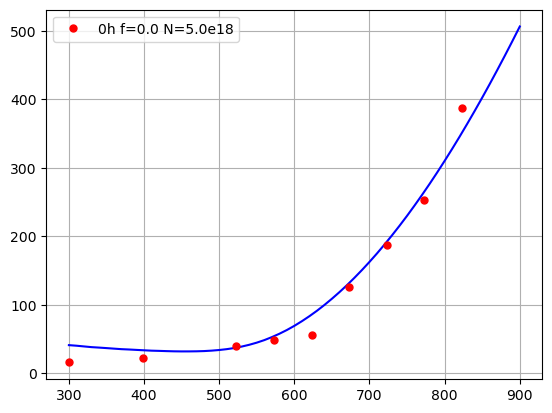

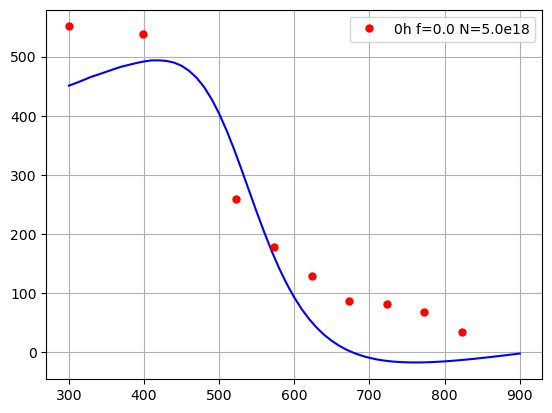

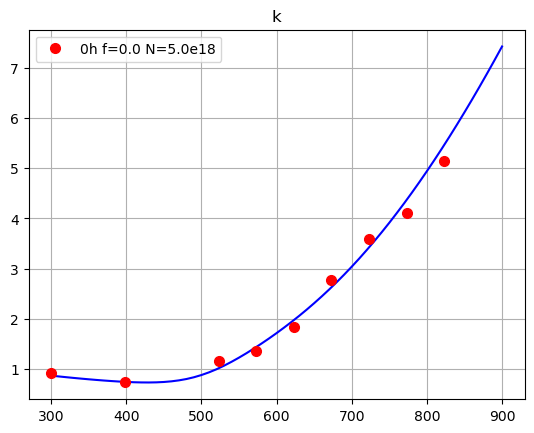

In [10]:
figure()
plot(Ts,sigmas[:,1,1]/100,linestyle="-",color="b")
plot(MgSiSn4hKCT .+273,MgSiSn0hECE,linestyle="None",marker=".",
    markersize=10,color="r",label=string("0h f=$f N=$(numofn[1])"))
grid()
legend(loc="upper left")
figure()
plot(Ts,seebecks[:,1,1]*1e6,linestyle="-",color="b")
plot(MgSiSn4hKCT .+273,MgSiSn0hSCS,linestyle="None",marker=".",
    markersize=10,color="r",label=string("0h f=$f N=$(numofn[1])"))
grid()
legend(loc="upper right")
figure()
title("k")
plot(Ts,klsT[:,1,1]+kes[:,1,1]+kbis[:,1,1],linestyle="-",color="b")
plot(MgSiSn4hKCT .+273,MgSiSn0hKCK,linestyle="None",marker="o",
    markersize=7,color="r",label=string("0h f=$f N=$(numofn[1])"))

legend(loc="upper left")
#ylim(1.5,3.5)
grid()

In [11]:
Ts

61-element Array{Float64,1}:
 300.0
 310.0
 320.0
 330.0
 340.0
 350.0
 360.0
 370.0
 380.0
 390.0
 400.0
 410.0
 420.0
   ⋮
 790.0
 800.0
 810.0
 820.0
 830.0
 840.0
 850.0
 860.0
 870.0
 880.0
 890.0
 900.0

In [12]:
foreach(x->println(ks[x,1,1]),1:length(Ts))

0.8742871570486391
0.8584822331414902
0.8432100900316182
0.8285435942158297
0.814643011316795
0.8013944268627448
0.7888513409077068
0.7771375356411432
0.766554547138618
0.7570725390818136
0.7490126282986032
0.7427559944215133
0.7390117125594202
0.7380392559280902
0.7406727803519
0.7479296792007766
0.7607805464147485
0.7800152175245356
0.8066829496143522
0.8420270612295435
0.8861921695852253
0.9392539493591615
1.001015355371687
1.0715812480315208
1.1490206626124277
1.2325001048113973
1.3211855263940429
1.4153486598470848
1.5130491394601209
1.614539675526588
1.7202228589721382
1.830314400310184
1.9443177238061349
2.0627812296566375
2.186552173142297
2.3153162218319396
2.4491520005223704
2.5883986020361545
2.7338580034276254
2.8848165668863666
3.0414978229382728
3.204068435075441
3.3732386297665564
3.54806849357882
3.7288425588633025
3.9156241232778752
4.109047015800919
4.308066588355938
4.51299695412224
4.724099955923734
4.941166579722456
5.163899086433293
5.39236138380234
5.626842414214

In [13]:
foreach(x->println(sigmas[x,1,1]),1:length(Ts))

4125.866875935226
4043.69473109961
3939.1682716542005
3836.4309853210043
3769.0792626748826
3695.1307838322814
3615.9087954540237
3539.3006436774567
3490.681096046714
3431.935706532161
3373.6346509900277
3319.6569695729863
3289.629004347501
3253.785939948089
3224.547973605943
3211.299340820756
3213.7969630084854
3227.6968283658766
3260.6998294296377
3324.992778371583
3416.53915608824
3540.258270161404
3703.0353892934913
3918.075253941719
4178.567998016595
4490.732224749756
4858.480691756542
5293.239377385153
5782.1777205182225
6330.136232842706
6941.145688518505
7615.912007654579
8346.323532793476
9134.5175639812
9986.485824029587
10895.17013264983
11857.919064997566
12875.687844329877
13956.27586829496
15088.160261101195
16272.190975633941
17508.972776566807
18807.41508600365
20153.14970976269
21549.391924145362
22996.50276801978
24503.786365839616
26055.30084006847
27655.71684059339
29309.22168140539
31012.83633158828
32762.195041925792
34558.67994253394
36407.39122442606
38301.55400

In [14]:
foreach(x->println(-seebecks[x,1,1]*1e6),1:length(Ts))

-451.03474967914843
-455.6143894678431
-460.78189462546385
-465.94962054318285
-470.142952934856
-474.4656934614721
-478.867877161811
-483.06921141850046
-486.1619896060921
-489.24606890655963
-491.84948992676806
-493.65070546002016
-493.6833441596853
-492.7023077697276
-489.89390770657565
-484.4711304166648
-475.9821047218972
-464.17356986784347
-448.4073214921981
-428.0393353887899
-403.3817049626084
-374.742289743933
-342.7328533992032
-308.07779281476485
-272.4439041979944
-237.0068509364508
-202.87603727478705
-170.73655061480255
-141.54500769466446
-115.48832663804416
-92.57105169113743
-72.69633532720458
-55.74112347287002
-41.38785577222648
-29.296104452237522
-19.231291717940458
-10.927647467946404
-4.127849439449753
1.4099246568836605
5.836072905911788
9.322110328321017
12.01169157194812
14.03514961523187
15.474828417349972
16.42371277486502
16.95642932666269
17.13862325540325
17.017070897614825
16.639875307518093
16.045939913685675
15.267701863729947
14.33389699999775
13.268

In [15]:
foreach(x->println(kes[x,1,1]),1:length(Ts))

0.019694326463654835
0.020618222096755675
0.021402958834271534
0.022112063953250174
0.022884166891668715
0.023573042926393336
0.02417718638862967
0.024732155655888162
0.025385148648796575
0.025938208811882135
0.026447606460787313
0.02694053167803502
0.027564709962439003
0.028118732761521707
0.02869421994076373
0.02937560507558409
0.03017489522994584
0.031063467319723197
0.032119746278957154
0.03347549252602368
0.03510889246451249
0.03708460365173989
0.039492711447649126
0.0425019651375092
0.04606125433063524
0.05026577511922048
0.05518938579060201
0.061007592144586564
0.06759106275232851
0.07503245105062067
0.08342069759541193
0.0928034367145536
0.1030995965811018
0.11437157567833356
0.12674497734831236
0.14014736248679216
0.15456769380540514
0.17005110513660715
0.18675976342563916
0.20453358846075198
0.22341439137261054
0.24344093146755297
0.2648037679788793
0.28727460303818675
0.31093790001140054
0.33582788867453517
0.36215230770521445
0.38963471299481367
0.41839095652807834
0.448532

In [16]:
foreach(x->println(kbis[x,1,1]),1:length(Ts))

2.918352799963965e-5
6.0340385860978885e-5
0.00011856160904180826
0.0002236348538316585
0.0004101875199775199
0.0007255380469298827
0.0012412869644702906
0.0020634794950248753
0.0033651953583054128
0.0053339525324544515
0.0082544225890517
0.0125006487508573
0.01865409085152994
0.0271956493508376
0.038887661065091915
0.054682562327387475
0.07555800371360989
0.10235102234892678
0.13605048577895681
0.17778539924962544
0.22773901849261713
0.2859385393408489
0.3521123485745371
0.4262114060086678
0.5063700373170171
0.591673069767454
0.6812254640401535
0.7751356795941234
0.871604299773082
0.9708024051922364
1.0730540985385144
1.1785373598274151
1.286846063590917
1.39847508760499
1.5141544802858204
1.6336502876727972
1.7570596761785546
1.884683695675542
2.017168854751925
2.1539679223086363
2.2952685920101836
2.4412044091105582
2.592300366988399
2.7478498787985948
2.9080577615362793
3.0729575663102637
3.2429796170088574
3.4173597079855336
3.5962998771101122
3.779954040833119
3.9681464178695185


In [17]:
foreach(x->println(klsT[x,1,1]),1:length(Ts))

0.8545636470569846
0.8378036706588735
0.8216885695883048
0.8062078954087478
0.7913486569051487
0.7770958458894216
0.7634328675546068
0.7503419004902302
0.7378042031315161
0.725800377737477
0.714310599248764
0.703314813992621
0.6927929117454513
0.6827248738157309
0.6730908993460444
0.663871511797805
0.6550476474711927
0.6466007278558856
0.6385127175564381
0.6307661694538944
0.6233442586280957
0.6162308063665727
0.6094102953495008
0.6028678768853436
0.5965893709647754
0.5905612599247229
0.5847706765632873
0.5792053881083747
0.5738537769347103
0.568704819283731
0.5637480628382119
0.5589736037682154
0.5543720636341162
0.5499345663733138
0.5456527155081643
0.5415185716723504
0.5375246305384104
0.5336638012240055
0.5299293852500612
0.5263150561169784
0.5228148395554788
0.5194230944973298
0.5161344947992782
0.5129440117420382
0.5098468973156226
0.5068386682930764
0.5039150910868471
0.501072167375591
0.4983061204840497
0.495613382494646
0.4929905820664207
0.49043453293479566
0.4879422230641740